#Predictive Linear Modeling

Now that we've seen how are basic outcomes and predictors behave, we can start to see if we can model them using some basic linear models. At this point, it makes most sense to characterize each pollutant each as their own regression as we see that they all act differently in the exploratory data analysis. We will just throw in all predictors first. This isn't the most principled approach as we may want to do some variable selection, but it may be a good starting point before moving into more sophisticated models to get a sense of the various factors that are important to each pollutant.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import csv
import urllib
import time

In [2]:
#Load in the 3 US datasets
YearDat = pd.read_csv('YearDat2.csv')
MonthDat = pd.read_csv('MonthDat2.csv')
SeasonDat = pd.read_csv('SeasonDat2.csv')

##Basic Multivariate Linear Regression

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols

In [4]:
#Make a predictor for cars in general -- pooling alone and carpooling
YearDat['car_frac'] = YearDat['carpool_frac']+YearDat['alone_frac']
YearDat['car'] = YearDat['carpool'] + YearDat['alone']

In [5]:
#Make a predictor of PT and Other (walk or bike) as these are
#things that have less emission
YearDat['pt_other_frac'] = YearDat['pt_frac']+YearDat['other_frac']
YearDat['pt_other'] = YearDat['pt']+YearDat['other']

In [6]:
#Make a dataframe for each pollutant, this makes it easier
#to deal with missing values later on
no2US_y = YearDat[pd.notnull(YearDat['NO2'])]
coUS_y = YearDat[pd.notnull(YearDat['CO'])]
so2US_y = YearDat[pd.notnull(YearDat['SO2'])]
ozoneUS_y = YearDat[pd.notnull(YearDat['OZONE'])]
pm25US_y = YearDat[pd.notnull(YearDat['PM25_FRMFEM'])]
pm10US_y = YearDat[pd.notnull(YearDat['PM10'])]

In [7]:
no2_model_y = ols('NO2 ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip',no2US_y).fit()
co_model_y = ols('CO ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip',coUS_y).fit()
so2_model_y = ols('SO2 ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip',so2US_y).fit()
ozone_model_y = ols('OZONE ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip',ozoneUS_y).fit()
pm25_model_y = ols('PM25_FRMFEM ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip',pm25US_y).fit()
pm10_model_y = ols('PM10 ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip',pm10US_y).fit()

C:\Users\Mark\Anaconda\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


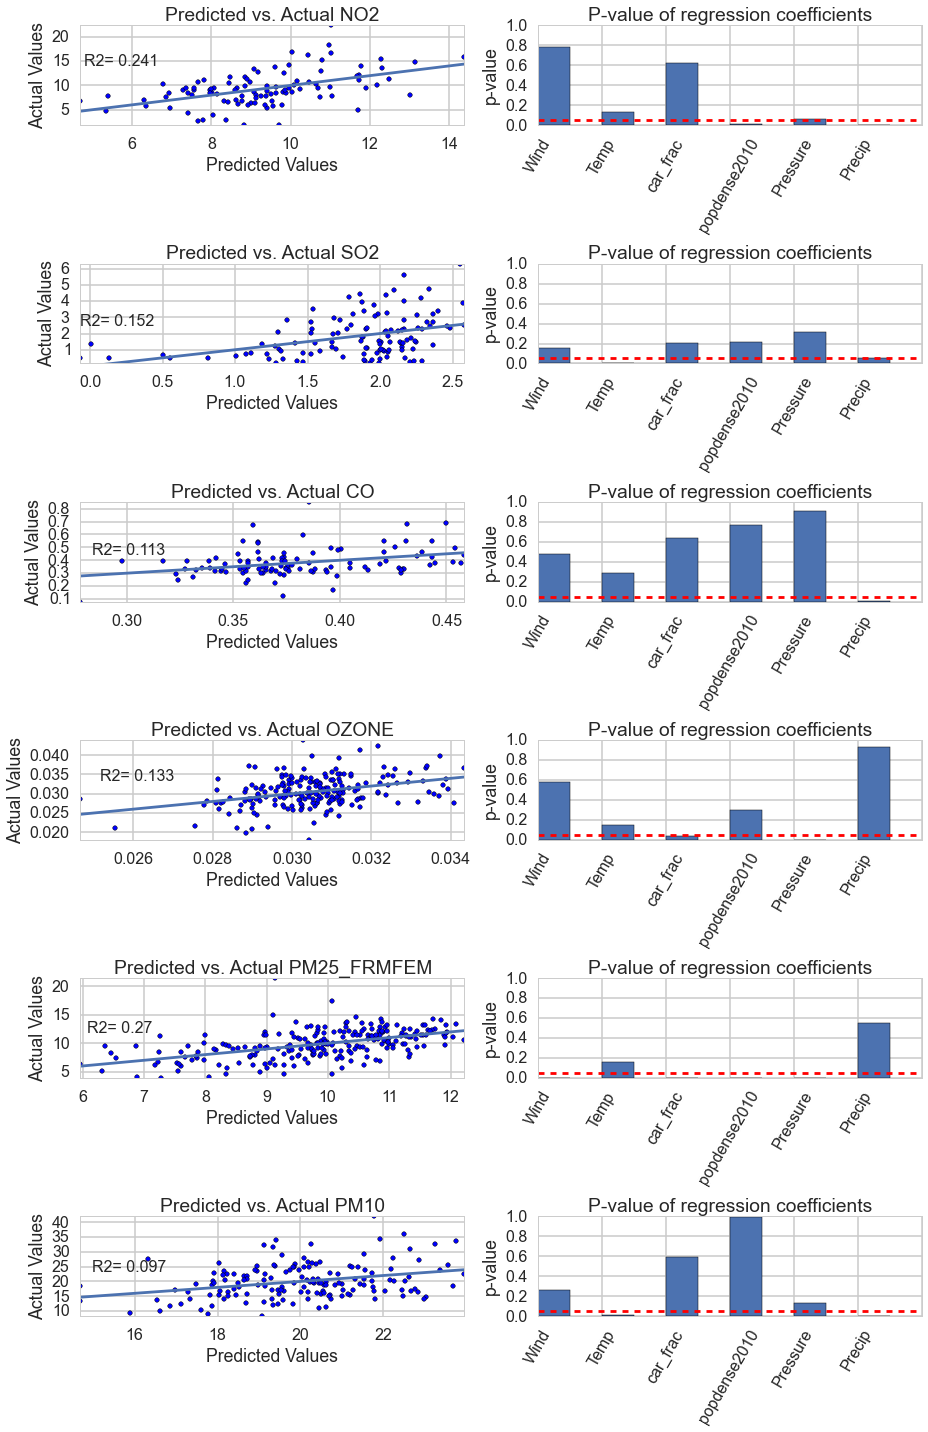

In [8]:
models_to_loop=[('NO2',no2_model_y,no2US_y),('NO2',no2_model_y,no2US_y),('SO2',so2_model_y,so2US_y),('SO2',so2_model_y,so2US_y),
                ('CO',co_model_y,coUS_y),('CO',co_model_y,coUS_y),('OZONE',ozone_model_y,ozoneUS_y),('OZONE',ozone_model_y,ozoneUS_y),
                ('PM25_FRMFEM',pm25_model_y,pm25US_y),('PM25_FRMFEM',pm25_model_y,pm25US_y),('PM10',pm10_model_y,pm10US_y),('PM10',pm10_model_y,pm10US_y)]
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(13, 20))
fig.set_tight_layout(True)

count = 0
for ax,j in zip(axes.ravel(),models_to_loop):
    count += 1
    if count % 2 != 0:
        ax.scatter(j[1].predict(),j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]])
        ax.plot([0,25], [0,25])
        ax.set_ylim((j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]]).min(),(j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]]).max())
        ax.set_xlim(j[1].predict().min(),j[1].predict().max())
        ax.set_ylabel('Actual Values')
        ax.set_xlabel('Predicted Values')
        ax.annotate('R2= '+str(round(j[1].rsquared,3)),xy=(j[1].predict().min()*1.02,j[1].predict().max()*.98),xytext=(j[1].predict().min()*1.02,j[1].predict().max()*.98),fontsize=16)
        ax.set_title('Predicted vs. Actual '+j[0])
    else:
        ax.bar([0,1,2,3,4,5],(sp.stats.t.sf(np.abs(j[1].tvalues), j[1].nobs-1)*2)[1:],.5)
        ax.set_ylim(0,1)
        ax.set_xticklabels(list(j[1].params.index)[1:],rotation=60,ha='center')
        ax.set_ylabel('p-value')
        ax.set_title('P-value of regression coefficients')
        ax.axhline(0.05,color='red',ls='--')

In general, these simple models don't fit perfectly, but we do get at least a bit fitting. The $R^2$ values range from 0.12 to 0.27 with the best $R^2$ for ozone. Perhaps more interesting are the particular predictors that are significantly associated with each pollutant, controlling for the other predictors. Average yearly wind is only a significant predictor for PM2.5, which makes some sense as this is small particulate matter and more likely to be influenced by wind than gases or larger particulates. Average yearly temperature seems to be significantly related to average yearly PM10 and CO. Average yearly air pressure is significantly related to PM2.5, ozone, and borderline for $NO_2$. Ozone and air pressure have a known relationship -- ozone increase with atmospheric pressure (lower elevation) (http://www.ucar.edu/communications/gcip/m1sod/m1pdfc1.pdf) so that makes sense. Precipiation influences the PM10, CO, $NO_2$, and $SO_2$. PM10 is large particulate matter so one could imagine how rain may wash some of that out of the air more than gases or small particulates. The relationship between $SO_2$ and precipitation may be a result of acid rain increasing atmospheric concentration. In general, rain be a natural way to clear pollutants from the air as we see it's significant relationship with many of the pollutants.

In terms of anthropogenic features, the fraction of individuals who commute via car (alone or carpool) only appears significant for ozone and PM2.5. It's interesting to see the impact it may have on exhaust emissions as well as paritculate matter. Population denisty is not significantly related to the pollutants in the context of the other variables, although it is borderline significant for the particulate matters which may not be surpising.

##Incorporating seasonal variation

We know the previous model is a bit naive given what we know about seasonal variation in pollutants and weather. Therefore it makes some sense to try to incorporate seasonality into the model in some form or another so that we aren't just looking at overall yearly averages. We can do this first quite naively by adding an indicator for season into the six models. Of course, when we do this, we now have 4 observations from each site (one from each season) so our Y's may be correlated. This could potentially be an issue and we would likely want to build a more sophisticated model, but it's worth just seeing how our regressions change with the naive approach first.

In [9]:
#Make a predictor for cars in general -- pooling alone and carpooling
SeasonDat['car_frac'] = SeasonDat['carpool_frac']+SeasonDat['alone_frac']
SeasonDat['car'] = SeasonDat['carpool'] + SeasonDat['alone']

In [10]:
#Make a predictor of PT and Other (walk or bike) as these are
#things that have less emission
SeasonDat['pt_other_frac'] = SeasonDat['pt_frac']+SeasonDat['other_frac']
SeasonDat['pt_other'] = SeasonDat['pt']+SeasonDat['other']

In [11]:
#Make a dataframe for each pollutant, this makes it easier
#to deal with missing values later on
no2US_s = SeasonDat[pd.notnull(SeasonDat['NO2'])]
coUS_s = SeasonDat[pd.notnull(SeasonDat['CO'])]
so2US_s = SeasonDat[pd.notnull(SeasonDat['SO2'])]
ozoneUS_s = SeasonDat[pd.notnull(SeasonDat['OZONE'])]
pm25US_s = SeasonDat[pd.notnull(SeasonDat['PM25_FRMFEM'])]
pm10US_s = SeasonDat[pd.notnull(SeasonDat['PM10'])]

In [12]:
no2_model_s = ols('NO2 ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip+season',no2US_s).fit()
co_model_s = ols('CO ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip+season',coUS_s).fit()
so2_model_s = ols('SO2 ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip+season',so2US_s).fit()
ozone_model_s = ols('OZONE ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip+season',ozoneUS_s).fit()
pm25_model_s = ols('PM25_FRMFEM ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip+season',pm25US_s).fit()
pm10_model_s= ols('PM10 ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip+season',pm10US_s).fit()

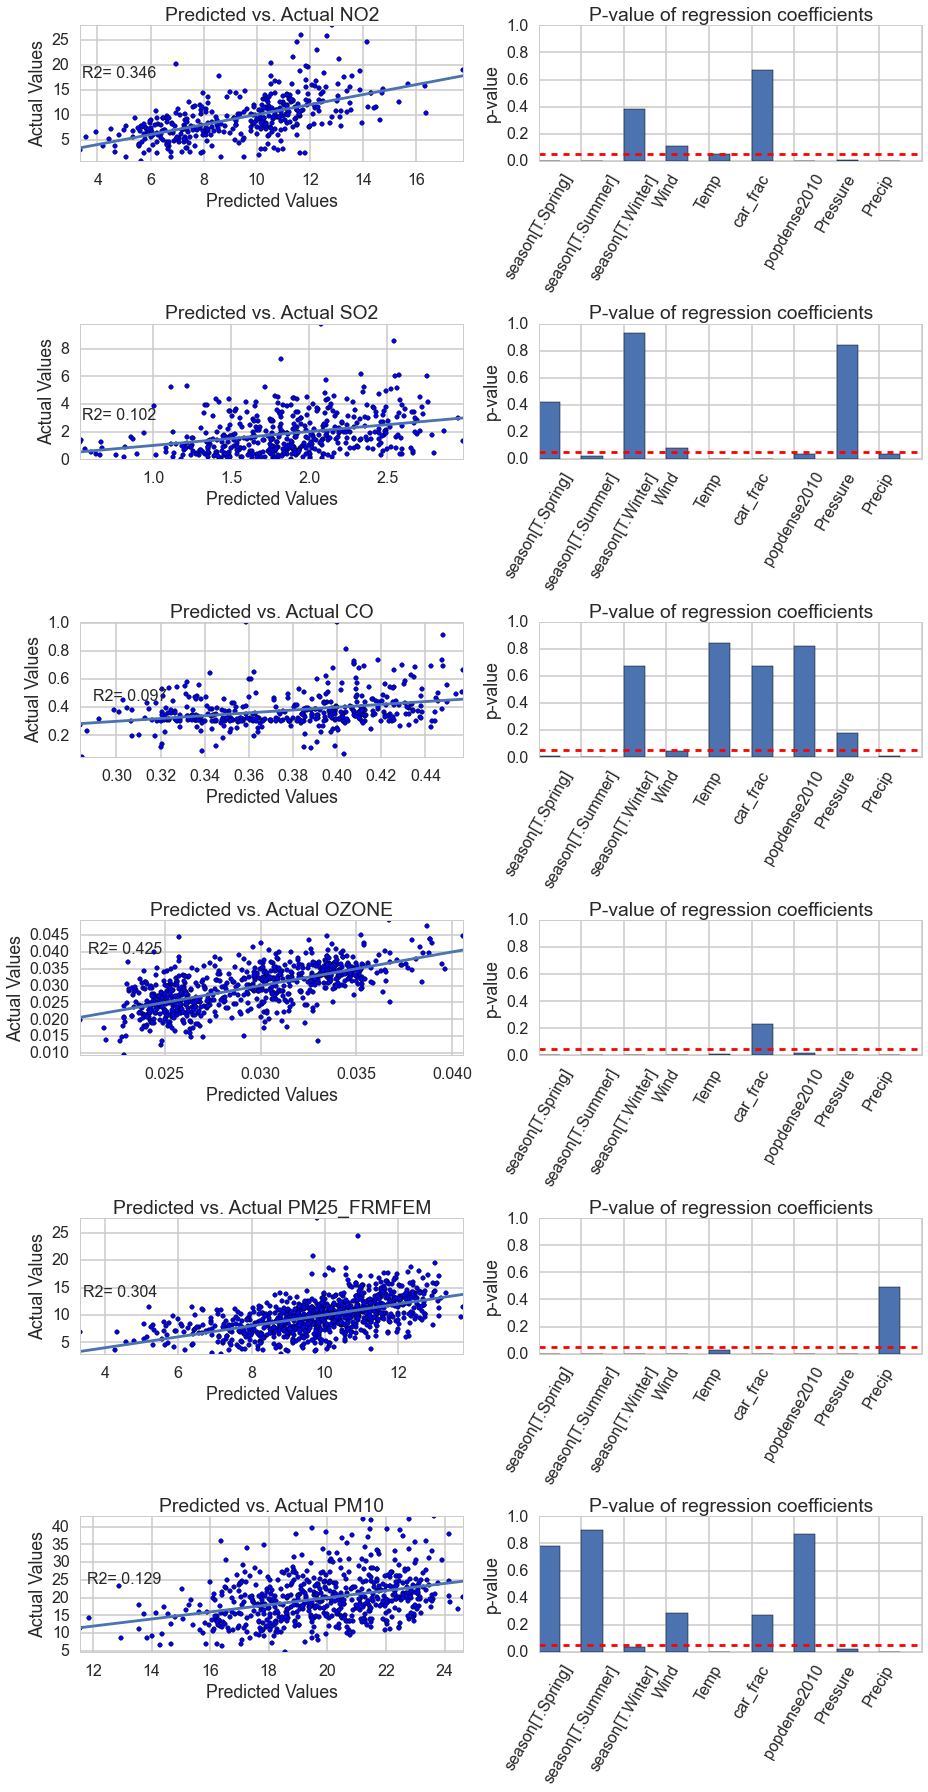

In [13]:
models_to_loop=[('NO2',no2_model_s,no2US_s),('NO2',no2_model_s,no2US_s),('SO2',so2_model_s,so2US_s),('SO2',so2_model_s,so2US_s),
                ('CO',co_model_s,coUS_s),('CO',co_model_s,coUS_s),('OZONE',ozone_model_s,ozoneUS_s),('OZONE',ozone_model_s,ozoneUS_s),
                ('PM25_FRMFEM',pm25_model_s,pm25US_s),('PM25_FRMFEM',pm25_model_s,pm25US_s),('PM10',pm10_model_s,pm10US_s),('PM10',pm10_model_s,pm10US_s)]
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(13, 25))
fig.set_tight_layout(True)

count = 0
for ax,j in zip(axes.ravel(),models_to_loop):
    count += 1
    if count % 2 != 0:
        ax.scatter(j[1].predict(),j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]])
        ax.plot([0,25], [0,25])
        ax.set_ylim((j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]]).min(),(j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]]).max())
        ax.set_xlim(j[1].predict().min(),j[1].predict().max())
        ax.set_ylabel('Actual Values')
        ax.set_xlabel('Predicted Values')
        ax.annotate('R2= '+str(round(j[1].rsquared,3)),xy=(j[1].predict().min()*1.02,j[1].predict().max()*.98),xytext=(j[1].predict().min()*1.02,j[1].predict().max()*.98),fontsize=16)
        ax.set_title('Predicted vs. Actual '+j[0])
    else:
        ax.bar([0,1,2,3,4,5,6,7,8],(sp.stats.t.sf(np.abs(j[1].tvalues), j[1].nobs-1)*2)[1:],.5)
        ax.set_ylim(0,1)
        ax.set_xticklabels(list(j[1].params.index)[1:],rotation=60,ha='center')
        ax.set_ylabel('p-value')
        ax.set_title('P-value of regression coefficients')
        ax.axhline(0.05,color='red',ls='--')

In general, this improved the model for many pollutants, but not all. Ozone, $NO_2$, and PM2.5 saw the greatest improvement in $R^2$ which isn't surprisingly given that they seemed to have more seasonal variation than the other pollutants. This leads us to believe that perhaps a time series model will give a more appropriate view of some of these pollutants as we are now obtaining $R^2$ that indicate a decent overall fit.

##Incorporating Monthly Variation

We can increase our granularity be looking a monthly variation instead of seasonal. This involves creating 11 dummy variables. Again, it may not be the most principled approach, but will give us an idea of whether a monthly model is worth pursuing.

In [14]:
#Make a predictor for cars in general -- pooling alone and carpooling
MonthDat['car_frac'] = MonthDat['carpool_frac']+MonthDat['alone_frac']

In [15]:
#Make a predictor of PT and Other (walk or bike) as these are
#things that have less emission
MonthDat['pt_other_frac'] = MonthDat['pt_frac']+MonthDat['other_frac']

In [16]:
MonthDat['month_c']=MonthDat['month'].astype('str')

In [17]:
#Make a dataframe for each pollutant, this makes it easier
#to deal with missing values later on
no2US_m = MonthDat[pd.notnull(MonthDat['NO2'])]
coUS_m = MonthDat[pd.notnull(MonthDat['CO'])]
so2US_m = MonthDat[pd.notnull(MonthDat['SO2'])]
ozoneUS_m = MonthDat[pd.notnull(MonthDat['OZONE'])]
pm25US_m = MonthDat[pd.notnull(MonthDat['PM25_FRMFEM'])]
pm10US_m = MonthDat[pd.notnull(MonthDat['PM10'])]

In [18]:
no2_model_m = ols('NO2 ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip+month_c',no2US_m).fit()
co_model_m = ols('CO ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip+month_c',coUS_m).fit()
so2_model_m = ols('SO2 ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip+month_c',so2US_m).fit()
ozone_model_m = ols('OZONE ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip+month_c',ozoneUS_m).fit()
pm25_model_m = ols('PM25_FRMFEM ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip+month_c',pm25US_m).fit()
pm10_model_m = ols('PM10 ~ Wind + Temp + car_frac + popdense2010 + Pressure + Precip+month_c',pm10US_m).fit()

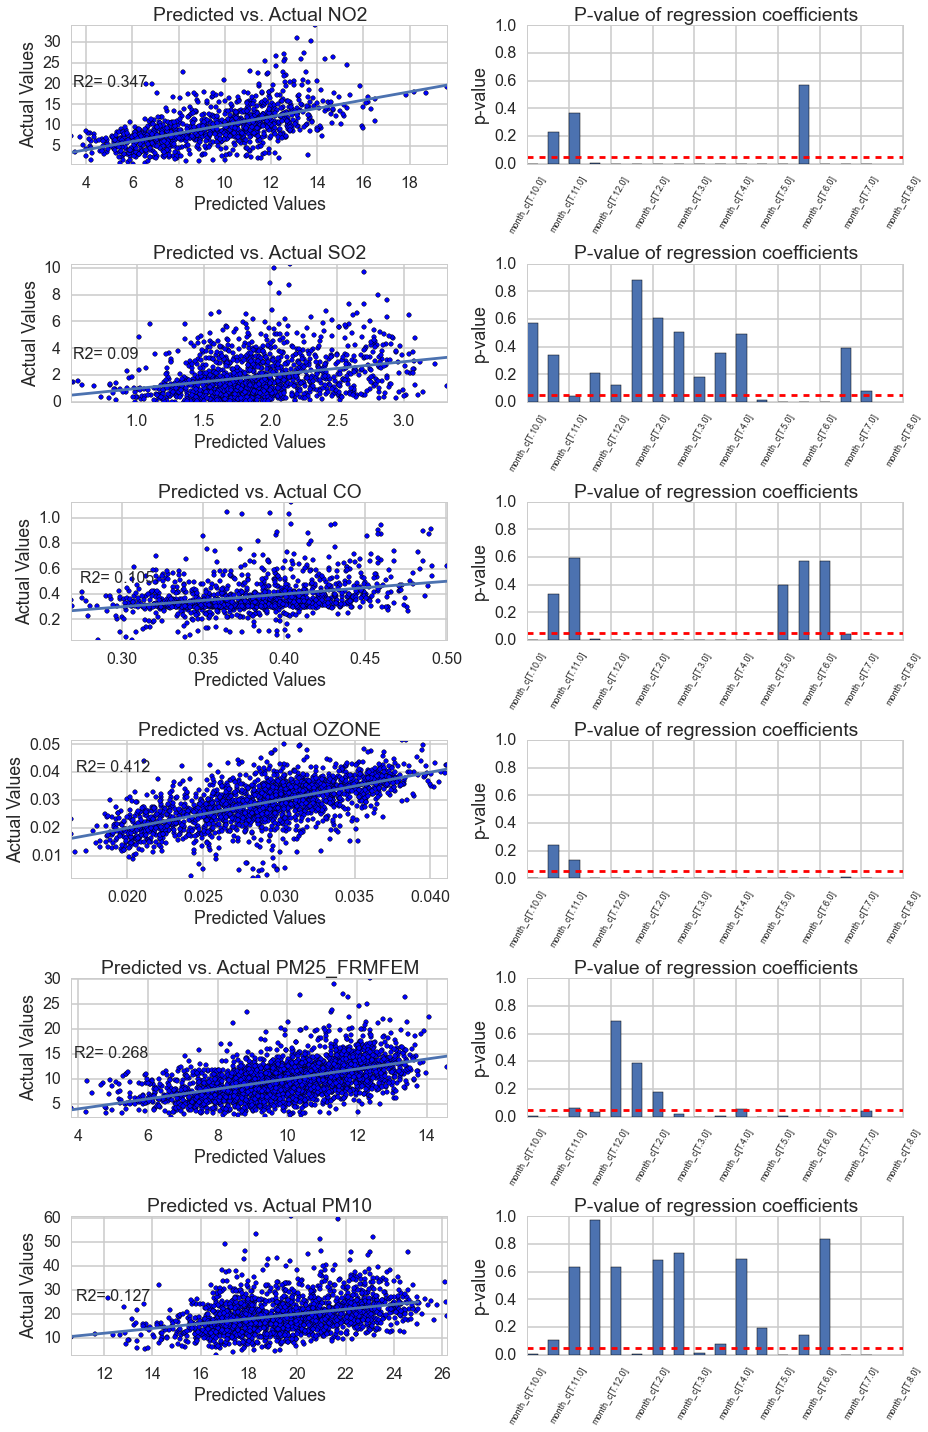

In [19]:
models_to_loop=[('NO2',no2_model_m,no2US_m),('NO2',no2_model_m,no2US_m),('SO2',so2_model_m,so2US_m),('SO2',so2_model_m,so2US_m),
                ('CO',co_model_m,coUS_m),('CO',co_model_m,coUS_m),('OZONE',ozone_model_m,ozoneUS_m),('OZONE',ozone_model_m,ozoneUS_m),
                ('PM25_FRMFEM',pm25_model_m,pm25US_m),('PM25_FRMFEM',pm25_model_m,pm25US_m),('PM10',pm10_model_m,pm10US_m),('PM10',pm10_model_m,pm10US_m)]
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(13, 20))
fig.set_tight_layout(True)

count = 0
for ax,j in zip(axes.ravel(),models_to_loop):
    count += 1
    if count % 2 != 0:
        ax.scatter(j[1].predict(),j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]])
        ax.plot([0,25], [0,25])
        ax.set_ylim((j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]]).min(),(j[2][[j[0],'Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()[j[0]]).max())
        ax.set_xlim(j[1].predict().min(),j[1].predict().max())
        ax.set_ylabel('Actual Values')
        ax.set_xlabel('Predicted Values')
        ax.annotate('R2= '+str(round(j[1].rsquared,3)),xy=(j[1].predict().min()*1.02,j[1].predict().max()*.98),xytext=(j[1].predict().min()*1.02,j[1].predict().max()*.98),fontsize=16)
        ax.set_title('Predicted vs. Actual '+j[0])
    else:
        ax.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],(sp.stats.t.sf(np.abs(j[1].tvalues), j[1].nobs-1)*2)[1:],.5)
        ax.set_ylim(0,1)
        ax.set_xticklabels(list(j[1].params.index)[1:],rotation=60,ha='center',fontsize=9)
        ax.set_ylabel('p-value')
        ax.set_title('P-value of regression coefficients')
        ax.axhline(0.05,color='red',ls='--')

We don't see much further improvement in the model fit by adding in the monthly indicator suggesting that it may be more beneficial to pursue the seasonal model.

##Autocorrelation

As we mentioned, there may be autocorrelation in our analysis because of the repeated observations across time in the same stations. One way to see if this is an issue is the Durbin-Watson statistic. We can calculate the value and compare it to the upper and lower bounds provided in the following table: https://www3.nd.edu/~wevans1/econ30331/Durbin_Watson_tables.pdf. If our statistic is lower than dL, then that's indicative of positive first-order autocorrelation. If it's larger than dU, then we wouldn't reject the null and conclude that there is not autocorrelation. If it's in between the two, it's uncertain but we would probably assume no autocorrelation to be conservative. 

*Yearly:* we have 6 predictors and roughly 100 observations in each regression (depending on missing values). Therefore dL~1.421 and dU~1.670.<br>

*Seasonally:* we have 9 predictors and over 200 observations in each regression. Therefore our dL=1.582 and dU=1.768.<br>

*Monthly:* we have 17 predictors and well over 200 observations. Therefore dL=1.495 and dU=1.860.

The calculations for each regression are as follows:

**Yearly:**

In [20]:
models_to_loop2=[('NO2',no2_model_y),('SO2',so2_model_y),('CO',co_model_y),('OZONE',ozone_model_y),
                ('PM25_FRMFEM',pm25_model_y),('PM10',pm10_model_y)]
for j in models_to_loop2:
    #Help with calculation from
    #http://connor-johnson.com/2014/02/18/linear-regression-with-python/
    print j[0] + ' Durbin-Watson: ' + str(np.sum( np.diff( j[1].resid.values )**2.0 ) / j[1].ssr)

NO2 Durbin-Watson: 1.71042289521
SO2 Durbin-Watson: 2.14282813839
CO Durbin-Watson: 2.09165309877
OZONE Durbin-Watson: 1.89853266325
PM25_FRMFEM Durbin-Watson: 1.83684431032
PM10 Durbin-Watson: 1.81439116034


These seem to have no autocorrelation as the statistics exceed the upper value. This is what we'd expect given that each site only has one observation as we've averaged across the year.

**Seasonally:**

In [21]:
models_to_loop2=[('NO2',no2_model_s),('SO2',so2_model_s),('CO',co_model_s),('OZONE',ozone_model_s),
                ('PM25_FRMFEM',pm25_model_s),('PM10',pm10_model_s)]
for j in models_to_loop2:
    #Help with calculation from
    #http://connor-johnson.com/2014/02/18/linear-regression-with-python/
    print j[0] + ' Durbin-Watson: ' + str(np.sum( np.diff( j[1].resid.values )**2.0 ) / j[1].ssr)

NO2 Durbin-Watson: 1.04028974216
SO2 Durbin-Watson: 0.950738812985
CO Durbin-Watson: 1.0785543714
OZONE Durbin-Watson: 1.43551626147
PM25_FRMFEM Durbin-Watson: 1.30976160807
PM10 Durbin-Watson: 1.06995200603


With the seasonal data, we're encountering a bit of significant positive first-order autocorrelation in our analysis as we've included multiple observations across time for each site. This might suggest that even though we had a better fit for a few of the pollutants using the seasonal data, we may need to use a time series model to account for it.

**Monthly:**

In [22]:
models_to_loop2=[('NO2',no2_model_m),('SO2',so2_model_m),('CO',co_model_m),('OZONE',ozone_model_m),
                ('PM25_FRMFEM',pm25_model_m),('PM10',pm10_model_m)]
for j in models_to_loop2:
    #Help with calculation from
    #http://connor-johnson.com/2014/02/18/linear-regression-with-python/
    print j[0] + ' Durbin-Watson: ' + str(np.sum( np.diff( j[1].resid.values )**2.0 ) / j[1].ssr)

NO2 Durbin-Watson: 0.559761553956
SO2 Durbin-Watson: 0.454875695697
CO Durbin-Watson: 0.595596176003
OZONE Durbin-Watson: 1.01047556203
PM25_FRMFEM Durbin-Watson: 0.89748451415
PM10 Durbin-Watson: 0.844790487666


The autocorrelation using the monthly data is not suprisingly substantially worse as we now have 12 observations for site. If we were to use the monthly data, we'd certainly need to incorporate some times series model to deal with the positive first-order autocorrelation.

##Selecting Independent Variables

Given that the seasonal model seems to work the best of the previous (barring the autocorrelation issue that we still need to deal with) we're going to just focus on that model. In the previous models, we just added all predictors into the models. This may not be the best approach, but perhaps we can use feature selection based on the correlations in the exploratory data analysis. For each regression, we can include predictors that have a correlation coefficient greater than 0.20 (a very liberal cutoff) in the absolute value during at least one season. This may not be the best feature selection process, but it may get rid of features that aren't really adding much information.

In [23]:
predictors = {}
pollutants = ['CO','NO2','OZONE','PM25_FRMFEM','PM10','SO2']
for p in pollutants:
    predictors[p]=[]
    choices_nontrans = ['Pressure','Temp','Wind','Precip','popdense2010']
    choices_trans = ['pt_frac','car_frac','other_frac']
    choices_nontrans = [p,'season'] + choices_nontrans
    choices_trans = [p,'season'] + choices_trans
    for seasonI in ['Winter','Spring','Summer','Fall']:
        sel_df_nontrans=SeasonDat[SeasonDat['season']==seasonI][choices_nontrans]
        corrmat_nontrans = sel_df_nontrans.corr()
        sel_df_trans=SeasonDat[SeasonDat['season']==seasonI][choices_trans]
        corrmat_trans = sel_df_trans.corr()
        for var,val in zip(list(corrmat_nontrans.iloc[:1].columns),corrmat_nontrans.iloc[:1].values.tolist()[0]):
            if (abs(val) > 0.2) and (var != p):
                predictors[p].append(var)
        for var,val in zip(list(corrmat_trans.iloc[:1].columns),corrmat_trans.iloc[:1].values.tolist()[0]):
            if (abs(val) > 0.2) and (var != p):
                predictors[p].append(var)

In [24]:
model_dict = {}
pollutants = ['CO','NO2','OZONE','PM25_FRMFEM','PM10','SO2']
dfs = [coUS_s,no2US_s,ozoneUS_s,pm25US_s,pm10US_s,so2US_s] 
trimmed_dfs = {}
for p, df in zip(pollutants,dfs):
    cleandf=df[[p,'season']+list(set(predictors[p]))].dropna()
    trimmed_dfs[p] = cleandf
    base = p+' ~ season + '
    for i in set(predictors[p]):
        base = base + i + ' + '
    model = base[:-3]
    print model
    model_dict[p] =  ols(model,cleandf).fit()

CO ~ season + Precip + Wind
NO2 ~ season + pt_frac + Pressure + popdense2010 + car_frac
OZONE ~ season + pt_frac + popdense2010 + Temp + car_frac + Pressure + Precip + Wind
PM25_FRMFEM ~ season + Temp + car_frac + other_frac + Pressure + Precip + Wind
PM10 ~ season + Pressure + Precip + Temp + other_frac
SO2 ~ season + Pressure + other_frac


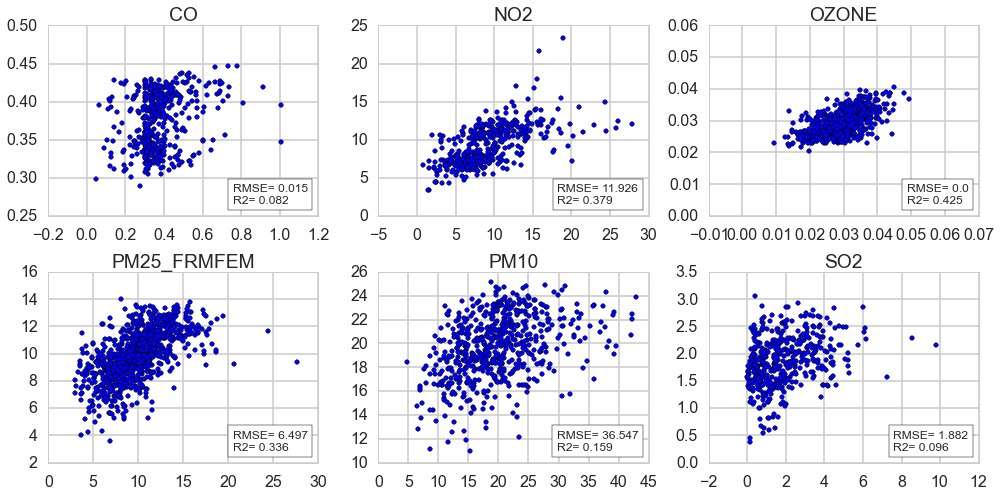

In [25]:
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))
fig.set_tight_layout(True)
for ax,p in zip(axes.ravel(),pollutants):
    ax.scatter(trimmed_dfs[p][p],model_dict[p].predict())
    ax.set_title(p)
    at = AnchoredText('RMSE= '+str(round(np.mean((trimmed_dfs[p][p] - model_dict[p].predict()) ** 2),3))+'\nR2= '+str(round(model_dict[p].rsquared,3)),
                  prop=dict(size=12), frameon=True,
                  loc=4,
                  )
    ax.add_artist(at)
  

Feature selection hasn't made drastic improvements in any of the evaulation metrics, but we did see slight increases for $NO_2$ and $PM2.5$. Given that these models are more simplistic and improve the fit, the feature selection was a minor success.

#Validation of Basic Regression in France Cities


We may be interested in seeing how the seasonal model with feature selection for each pollutant generalizes to cities outside the US. To do this, we will look at the French city data.

In [91]:
#Load French City Data
FranceYearDat = pd.read_csv('FranceYearDat.csv')
FranceSeasonDat = pd.read_csv('FranceSeasonDat.csv')

In [92]:
#Rename columns so they match the columns precisely in the other data
FranceSeasonDat.columns = ['season','SO2','NO2','CO','OZONE','PM10','PM25','id','city','population','popdense2010','area','other_frac','car_frac',
                        'pt_frac','Car','PT','Other','Temp','RH','Pressure','Wind','Precip']
FranceYearDat.columns = ['CO','NO2','OZONE','PM10','PM25','SO2','city','id','population','popdense2010','area','other_frac','car_frac',
                        'pt_frac','Car','PT','Other','latitude','longitude','Precip','Pressure','RH','site','Temp','Wind']


In [93]:
from sklearn.linear_model import LinearRegression
X_usdict={}
y_usdict={}
for p in pollutants:
    lm=LinearRegression()
    X_usdict[p] = trimmed_dfs[p].drop(p,axis=1)
    X_usdict[p]['winter'] = [1 if x=='Winter' else 0 for x in X_usdict[p]['season']]
    X_usdict[p]['spring'] = [1 if x=='Spring' else 0 for x in X_usdict[p]['season']]
    X_usdict[p]['summer'] = [1 if x=='Summer' else 0 for x in X_usdict[p]['season']]
    X_usdict[p] = X_usdict[p].drop('season',axis=1)
    y_usdict[p] = trimmed_dfs[p][p]

for p in pollutants:
    lm.fit(X_usdict[p],y_usdict[p])
    if p == 'PM25_FRMFEM':
        france_trim = FranceSeasonDat[['PM25','season']+list(set(predictors[p]))].dropna()
    else:
        france_trim = FranceSeasonDat[[p,'season']+list(set(predictors[p]))].dropna()
    france_trim['winter'] = [1 if x=='Winter' else 0 for x in france_trim['season']]
    france_trim['spring'] = [1 if x=='Spring' else 0 for x in france_trim['season']]
    france_trim['summer'] = [1 if x=='Summer' else 0 for x in france_trim['season']]
    france_trim = france_trim.drop('season',axis=1)

    if p == 'PM25_FRMFEM':
        france_X = france_trim.drop('PM25',axis=1)
        france_y = france_trim['PM25']
    else:
        france_X = france_trim.drop(p,axis=1)
        france_y = france_trim[p]
     
    if p == 'OZONE':
        print p
        print 'RMSE US Data: ' + str(round(np.mean((y_usdict[p] - lm.predict(X_usdict[p])) ** 2),5))
        print 'RMSE France Data: ' + str(round(np.mean((france_y - lm.predict(france_X)) ** 2),5))    
    else:
        print p
        print 'RMSE US Data: ' + str(round(np.mean((y_usdict[p] - lm.predict(X_usdict[p])) ** 2),3))
        print 'RMSE France Data: ' + str(round(np.mean((france_y - lm.predict(france_X)) ** 2),3))

CO
RMSE US Data: 0.015
RMSE France Data: 0.021
NO2
RMSE US Data: 11.926
RMSE France Data: 187.624
OZONE
RMSE US Data: 2e-05
RMSE France Data: 4e-05
PM25_FRMFEM
RMSE US Data: 6.497
RMSE France Data: 295.941
PM10
RMSE US Data: 36.547
RMSE France Data: 365.678
SO2
RMSE US Data: 1.882
RMSE France Data: 12.451


This doesn't look like it generalizes very well at all given the large difference in RMSE. It could be differences in the collection method of data, or it could simply be that emissions are different in France than the US. Regardless, as a predictive model, we would not feel that we would have very much ability to predict pollutants externally of the US with this model we've developed. One brute force evaluation is to fit the same parameters in both models and take a look at how the coefficients from the models differ between the two countries. It may be a certain set of predictors that really mess up the model in general.

In [94]:
from sklearn.linear_model import LinearRegression
X_usdict={}
y_usdict={}
for p in pollutants:
    lm=LinearRegression()
    X_usdict[p] = trimmed_dfs[p].drop(p,axis=1)
    X_usdict[p]['winter'] = [1 if x=='Winter' else 0 for x in X_usdict[p]['season']]
    X_usdict[p]['spring'] = [1 if x=='Spring' else 0 for x in X_usdict[p]['season']]
    X_usdict[p]['summer'] = [1 if x=='Summer' else 0 for x in X_usdict[p]['season']]
    X_usdict[p] = X_usdict[p].drop('season',axis=1)
    y_usdict[p] = trimmed_dfs[p][p]
    lm=LinearRegression()

for p in pollutants:
    lm.fit(X_usdict[p],y_usdict[p])
    print 'US parameter estimates'
    print lm.score(X_usdict[p],y_usdict[p])
    print list(X_usdict[p].columns)
    print lm.coef_
    if p == 'PM25_FRMFEM':
        france_trim = FranceSeasonDat[['PM25','season']+list(set(predictors[p]))].dropna()
    else:
        france_trim = FranceSeasonDat[[p,'season']+list(set(predictors[p]))].dropna()
    france_trim['winter'] = [1 if x=='Winter' else 0 for x in france_trim['season']]
    france_trim['spring'] = [1 if x=='Spring' else 0 for x in france_trim['season']]
    france_trim['summer'] = [1 if x=='Summer' else 0 for x in france_trim['season']]
    france_trim = france_trim.drop('season',axis=1)

    if p == 'PM25_FRMFEM':
        france_X = france_trim.drop('PM25',axis=1)
        france_y = france_trim['PM25']
    else:
        france_X = france_trim.drop(p,axis=1)
        france_y = france_trim[p]
    lm.fit(france_X,france_y)
    print 'France parameter estimates'
    print list(france_X.columns)
    print lm.coef_

US parameter estimates
0.0817246075433
['Precip', 'Wind', 'winter', 'spring', 'summer']
[ -6.38353460e-05  -5.93516341e-03   1.29465210e-02  -4.44668583e-02
  -6.38463802e-02]
France parameter estimates
['Precip', 'Wind', 'winter', 'spring', 'summer']
[  3.13377048e-05  -1.71324756e-02   9.43941320e-02  -8.16908494e-02
  -1.30339721e-01]
US parameter estimates
0.379216939889
['pt_frac', 'Pressure', 'popdense2010', 'car_frac', 'winter', 'spring', 'summer']
[  7.84873562e+01  -2.43775608e-01   1.22594647e-04   3.80212092e+01
   1.02415701e+00  -3.89840171e+00  -4.65732016e+00]
France parameter estimates
['pt_frac', 'Pressure', 'popdense2010', 'car_frac', 'winter', 'spring', 'summer']
[ -1.90920922e+01  -1.41093102e-01   3.09961039e-03  -4.09163605e+01
   2.27390297e+00  -2.64951036e+00  -4.74006989e+00]
US parameter estimates
0.424524464624
['pt_frac', 'popdense2010', 'Temp', 'car_frac', 'Pressure', 'Precip', 'Wind', 'winter', 'spring', 'summer']
[ -4.10110304e-04  -1.47416462e-06   5.97

It seems to be the transit variables -- they often switch signs in the different data sources. We know that we took those from fairly different sources, so maybe it's not comparable. Looking at correlations of the variables in a heatmap, we see quite differnt patterns with the transit and pollutants in the French data than the US data.

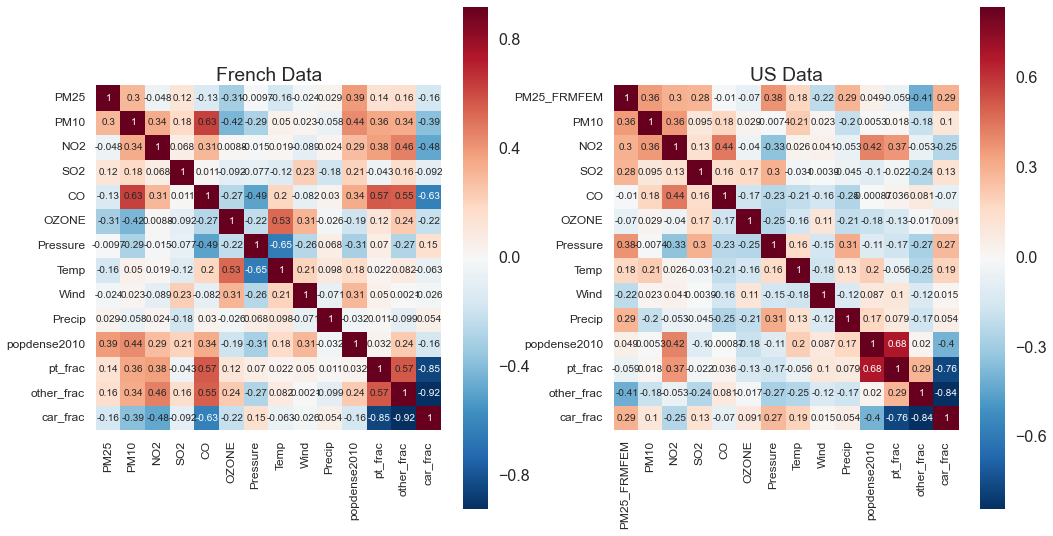

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 9))
df = FranceYearDat[['PM25','PM10','NO2','SO2','CO','OZONE','Pressure','Temp','Wind','Precip','popdense2010','pt_frac','other_frac','car_frac']]
corrmat = df.corr()
sns.heatmap(corrmat, vmax=.8, square=True,annot=True,ax=axes[0])
df = YearDat[['PM25_FRMFEM','PM10','NO2','SO2','CO','OZONE','Pressure','Temp','Wind','Precip','popdense2010','pt_frac','other_frac','car_frac']]
corrmat = df.corr()
sns.heatmap(corrmat, vmax=.8, square=True,annot=True,ax=axes[1])
axes[0].set_title('French Data')
axes[0].tick_params(labelsize=12)
axes[1].set_title('US Data')
axes[1].tick_params(labelsize=12)

This could mean one of three things:
1. The relationship between transportation style and pollutants is different in both countries. This could be possible, but seems unlikely.
2. More likely, the public transit data isn't really comparable between the two countries. The source of European transit data may not be the most robust -- some of it was relevant to the entire urban area and some seemed more city specific. This could have skewed the variable a bit.
3. The fraction of transportation may be completely different between countries so our model doesn't generalize well.

Just as a curiosity, what if we fit models only using the weather and population density -- variables that seem to have more similar relationships in both countries as they come from more reliable sources.

In [96]:
predictors2 = {}
pollutants = ['CO','NO2','OZONE','PM25_FRMFEM','PM10','SO2']
for p in pollutants:
    predictors2[p]=[]
    choices_nontrans2 = ['Pressure','Temp','Wind','Precip','popdense2010']
    choices_nontrans2 = [p,'season'] + choices_nontrans
    for seasonI in ['Winter','Spring','Summer','Fall']:
        sel_df_nontrans2=SeasonDat[SeasonDat['season']==seasonI][choices_nontrans2]
        corrmat_nontrans2 = sel_df_nontrans2.corr()
        for var,val in zip(list(corrmat_nontrans2.iloc[:1].columns),corrmat_nontrans2.iloc[:1].values.tolist()[0]):
            if (abs(val) > 0.2) and (var != p):
                predictors2[p].append(var)

In [97]:
model_dict2 = {}
pollutants = ['CO','NO2','OZONE','PM25_FRMFEM','PM10','SO2']
dfs = [coUS_s,no2US_s,ozoneUS_s,pm25US_s,pm10US_s,so2US_s] 
trimmed_dfs2 = {}
for p, df in zip(pollutants,dfs):
    cleandf=df[[p,'season']+list(set(predictors2[p]))].dropna()
    trimmed_dfs2[p] = cleandf
    base = p+' ~ season + '
    for i in set(predictors2[p]):
        base = base + i + ' + '
    model = base[:-3]
    print model
    model_dict2[p] =  ols(model,cleandf).fit()

CO ~ season + Precip + SO2 + Wind
NO2 ~ season + Pressure + popdense2010 + SO2
OZONE ~ season + Pressure + Precip + popdense2010 + Temp + Wind
PM25_FRMFEM ~ season + Pressure + Precip + Wind + SO2 + Temp
PM10 ~ season + Pressure + Precip + Temp
SO2 ~ season + Pressure


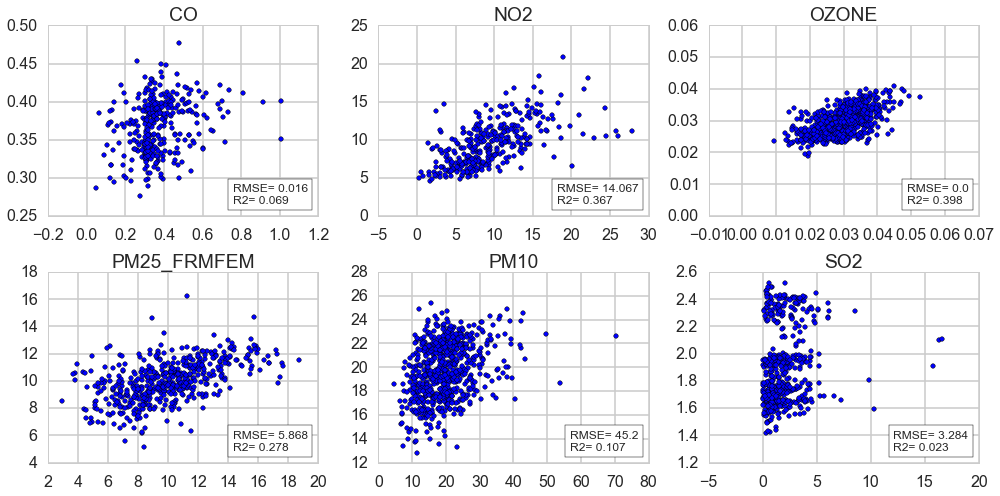

In [98]:
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))
fig.set_tight_layout(True)
for ax,p in zip(axes.ravel(),pollutants):
    ax.scatter(trimmed_dfs2[p][p],model_dict2[p].predict())
    ax.set_title(p)
    at = AnchoredText('RMSE= '+str(round(np.mean((trimmed_dfs2[p][p] - model_dict2[p].predict()) ** 2),3))+'\nR2= '+str(round(model_dict2[p].rsquared,3)),
                  prop=dict(size=12), frameon=True,
                  loc=4,
                  )
    ax.add_artist(at)

We lose some of our fit by dropping the transit variables, but not actually that much overall. This allow for us to do more robust testing. Let's recompare the RMSE using the French City data.

In [99]:
from sklearn.linear_model import LinearRegression
X_usdict2={}
y_usdict2={}
for p in pollutants:
    lm=LinearRegression()
    X_usdict2[p] = trimmed_dfs2[p].drop(p,axis=1)
    X_usdict2[p]['winter'] = [1 if x=='Winter' else 0 for x in X_usdict2[p]['season']]
    X_usdict2[p]['spring'] = [1 if x=='Spring' else 0 for x in X_usdict2[p]['season']]
    X_usdict2[p]['summer'] = [1 if x=='Summer' else 0 for x in X_usdict2[p]['season']]
    X_usdict2[p] = X_usdict2[p].drop('season',axis=1)
    y_usdict2[p] = trimmed_dfs2[p][p]

In [101]:
for p in pollutants:
    lm.fit(X_usdict2[p],y_usdict2[p])
    if p == 'PM25_FRMFEM':
        france_trim = FranceSeasonDat[['PM25','season']+list(set(predictors2[p]))].dropna()
    else:
        france_trim = FranceSeasonDat[[p,'season']+list(set(predictors2[p]))].dropna()
    france_trim['winter'] = [1 if x=='Winter' else 0 for x in france_trim['season']]
    france_trim['spring'] = [1 if x=='Spring' else 0 for x in france_trim['season']]
    france_trim['summer'] = [1 if x=='Summer' else 0 for x in france_trim['season']]
    france_trim = france_trim.drop('season',axis=1)

    if p == 'PM25_FRMFEM':
        france_X = france_trim.drop('PM25',axis=1)
        france_y = france_trim['PM25']
    else:
        france_X = france_trim.drop(p,axis=1)
        france_y = france_trim[p]
        
    if p == 'OZONE':
        print p
        print 'RMSE US Data: ' + str(round(np.mean(( - lm.predict(X_usdict2[p])) ** 2),5))
        print 'RMSE France Data: ' + str(round(np.mean((france_y - lm.predict(france_X)) ** 2),5))    
    else:
        print p
        print 'RMSE US Data: ' + str(round(np.mean((y_usdict2[p] - lm.predict(X_usdict2[p])) ** 2),3))
        print 'RMSE France Data: ' + str(round(np.mean((france_y - lm.predict(france_X)) ** 2),3))

CO
RMSE US Data: 0.016
RMSE France Data: 0.013
NO2
RMSE US Data: 14.067
RMSE France Data: 21.27
OZONE
RMSE US Data: 0.00089
RMSE France Data: 5e-05
PM25_FRMFEM
RMSE US Data: 5.868
RMSE France Data: 86.422
PM10
RMSE US Data: 45.2
RMSE France Data: 73.002
SO2
RMSE US Data: 3.284
RMSE France Data: 1.908


Well, the results seem somewhat better now. In fact, the model fits the French data a little better in some cases. I wouldn't say the US model is very generalizable still, but at least the validation seems to show a little bit of an improvement.

It could be interesting to look at residual plots for each of these regressions to see how if there are particular observations contributing to the higher RMSE.

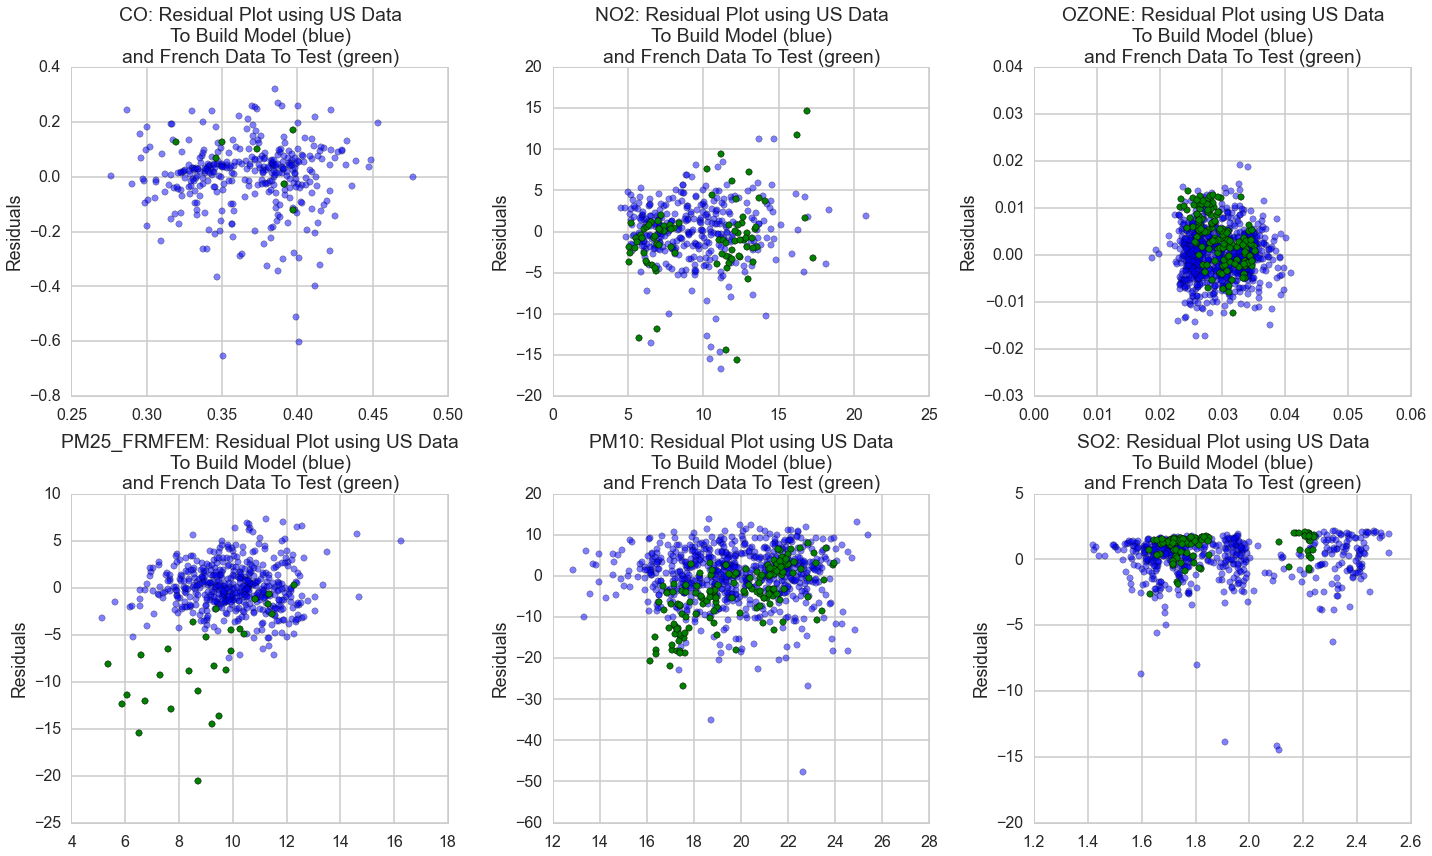

In [111]:
#Using some of the previous lab code
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
fig.set_tight_layout(True)
for ax,p in zip(axes.ravel(),pollutants):
    lm.fit(X_usdict2[p],y_usdict2[p])
    if p == 'PM25_FRMFEM':
        france_trim = FranceSeasonDat[['PM25','season']+list(set(predictors2[p]))].dropna()
    else:
        france_trim = FranceSeasonDat[[p,'season']+list(set(predictors2[p]))].dropna()
        
    france_trim['winter'] = [1 if x=='Winter' else 0 for x in france_trim['season']]
    france_trim['spring'] = [1 if x=='Spring' else 0 for x in france_trim['season']]
    france_trim['summer'] = [1 if x=='Summer' else 0 for x in france_trim['season']]
    france_trim = france_trim.drop('season',axis=1)

    if p == 'PM25_FRMFEM':
        france_X = france_trim.drop('PM25',axis=1)
        france_y = france_trim['PM25']
    else:
        france_X = france_trim.drop(p,axis=1)
        france_y = france_trim[p]
    
    ax.scatter(lm.predict(X_usdict2[p]), lm.predict(X_usdict2[p]) - y_usdict2[p], c='b', s=40, alpha=0.5)
    ax.scatter(lm.predict(france_X), lm.predict(france_X) - france_y, c='g', s=40)
    ax.set_title(p+': Residual Plot using US Data \nTo Build Model (blue) \nand French Data To Test (green)')
    ax.set_ylabel('Residuals')

Generally, it looks as if the France data falls within the US data in terms of residuals pretty decently. Because of missing data, we see very few France data points of CO and not a ton of PM25 either. In the case of the PM25, the French city residuals are quite far from 0 which is why there is such a high RMSE for the French data there. The other 4 plots look decently. It's interesting to se the two groups of SO2 that are well divided. The residuals for NO2, OZONE, and PM10 look pretty much like we'd like to see.

##Honing in on the $NO_2$ and $OZONE$ Models

Of all the models, the $NO_2$  and $ozone$ models look most promising. We will work with these to see if we can generate a more principled modeling approach to account for the autcorrelation.

##Mixed Effects Model

One potential way to deal with the correlated responses in the seasonal model is to incorporate a random effect of `site` into he model. The idea of a mixed effects model would be to treat each individual measurement from a station as a draw from all possible draws in that station. The classic examples for these types of models often come from the realm of education. If you have a bunch of student reponses for a set of 100 schools, then students within a certain school may have responses more closely correlated with one another because of shared experience in comparison with measures between schools. If we just pool all the students into one large sample and run a regression, we're overlooking this.

This is analagous to our situation. Observations from the same site are probably correlated with one another so when we include all 4 seasonal ob

##Time Series Model

In [296]:
from statsmodels.graphics.api import qqplot

In [297]:
print sm.datasets.sunspots.NOTE

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [298]:
dta = sm.datasets.sunspots.load_pandas().data

In [302]:
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]

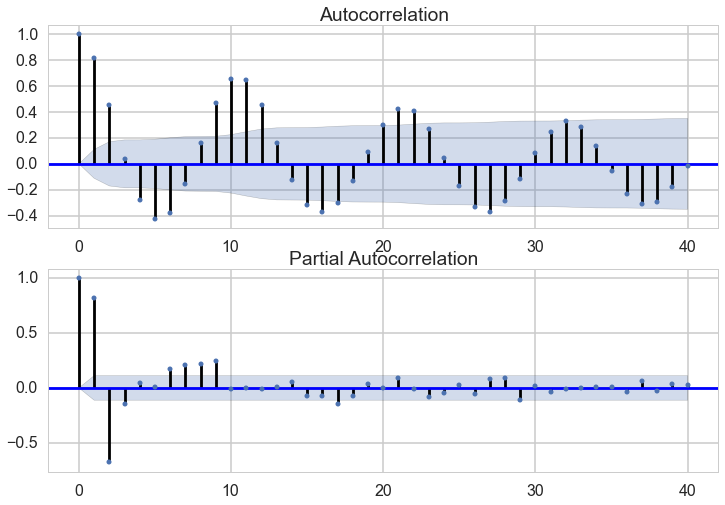

In [304]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=40, ax=ax2)

In [ ]:
http://conference.scipy.org/proceedings/scipy2011/pdfs/statsmodels.pdf

In [230]:
tsa = sm.tsa

In [286]:
mdata=sm.datasets.macrodata.load().data
endog = np.log(mdata['m1'])
exog = np.column_stack([np.log(mdata['realgdp']),
np.log(mdata['cpi'])])
exog = sm.add_constant(exog, prepend=True)
res1 = sm.OLS(endog, exog).fit()
print res1.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     9871.
Date:                Thu, 03 Dec 2015   Prob (F-statistic):          1.34e-200
Time:                        14:53:42   Log-Likelihood:                 221.75
No. Observations:                 203   AIC:                            -437.5
Df Residuals:                     200   BIC:                            -427.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -1.5016      0.353     -4.256      0.0

In [295]:
import statsmodels.tsa.arima_process as tsp
ar = np.r_[1., -0.5, -0.2]; ma = np.r_[1., 0.2, -0.2]
np.random.seed(123)
x = tsp.arma_generate_sample(ar, ma, 20000, burnin=1000)
sm.tsa.pacf(x, 5)
#array([1., 0.675, -0.053, 0.138, -0.018, 0.038])
ap = tsp.ArmaProcess(ar, ma)
ap.pacf(5)
#array([1., 0.666, -0.035, 0.137, -0.034, 0.034])

array([ 1.        ,  0.66581395, -0.03455854,  0.13686029, -0.03388903])

In [33]:
print len(no2F[['NO2','Wind','Temp','pt_frac','popdense2010','Pressure','Precip']].dropna()['NO2'])
print len(no2_model.predict())

103
103


In [ ]:
import numpy as np
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(np.array(coF[['NO2','WIND','PRESS','RH','TEMP','popdense2010','pt_frac']]))
X = np.array(coF[['NO2','WIND','PRESS','RH','TEMP','popdense2010','pt_frac']])
imputedFrame = pd.DataFrame(imp.transform(X))
imputedFrame.columns = ['NO2','WIND','PRESS','RH','TEMP','popdense2010','pt_frac']

In [ ]:
imputedFrame.head()

In [ ]:
ols_model = ols('NO2 ~ WIND + TEMP + pt_frac + popdense2010 + PRESS + RH',imputedFrame).fit()
ols_model
ols_model.summary()

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols

In [ ]:
from statsmodels.regression.mixed_linear_model import MixedLM, MixedLMParams

In [ ]:
SeasonDat['car_frac'] = SeasonDat['carpool_frac']+SeasonDat['alone_frac']
SeasonDat['pt_other_frac'] = SeasonDat['pt_frac']+SeasonDat['other_frac']

In [ ]:
sDat2 = SeasonDat[['NO2','WIND','popdense2010','RH','season','CBSA Name']]
sDat2.dropna(inplace=True)

In [ ]:
vcf = {"season" : "1 + C(season)"}

In [ ]:
mixed_model = MixedLM.from_formula('NO2 ~ WIND + popdense2010 + RH + season', data = sDat2, groups=sDat2["CBSA Name"], vc_formula=vcf)

In [ ]:
result = mixed_model.fit()

In [ ]:
print result.summary()

In [ ]:
result.predict()

In [ ]:
['WIND','popdense2010','RH','season','CBSA Name']

In [ ]:
ols_model = ols('NO2 ~ WIND + TEMP + pt_frac + popdense2010 + PRESS + RH + season',SeasonDat).fit()
ols_model
ols_model.summary()

In [ ]:
statsmodels.regression.mixed_linear_model.MixedLM

In [ ]:
outcomes = ['AQI_PM25_FRMFEM',"AQI_PM10","AQI_CO","AQI_NO2",'AQI_SO2','AQI_OZONE']
predictors = ['WIND','TEMP','RH','PRESS','popdense2010']
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(16, 14), 
                         tight_layout=True)
count = 0
for pol in outcomes:
    for pred in predictors:
        ax = axes.ravel()[count]
        plotting_dat = YearDat[[pol,pred]]
        ax.scatter(plotting_dat[pol],plotting_dat[pred])
        count += 1
        ax.set_title(pol)
        ax.set_ylabel(pred)
        #ax.annotate(pol, xy=(np.min(plotting_dat[pol]), np.max(plotting_dat[pred])), fontsize=14)